In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [3]:
from w266_common import utils, vocabulary
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the data

In [4]:
data_path = '/home/yulia/final-project/data/raw/hein-daily'

In [5]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [6]:
len(all_speech_ids), len(all_speeches)

(3866201, 3866201)

## Create target labels

In [ ]:
# OPEN descr FROM A SAVED FILE (if it was previously saved)
outdata_path = '/home/yulia/final-project/Classification/data'
descr = pickle.load(open(os.path.join(outdata_path, 'descr.p'), 'rb'))

In [8]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data('/home/yulia/final-project/data/QA/full_descr.txt', p=1)
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

Random congressperson: 1040147117
date 19951101
char_count 1332
word_count 232
speakerid 104119920.0
Party D
Congress 104
Chamber H
State TX
Ethnicity B
Age 46.0
Age_lt_med 1.0
NonWhite 1.0
Female 1.0
speaker Ms. JACKSON-LEE
Full Name JACKSON LEE, SHEILA
match exact

It took 101.0 seconds to create the dictionary


In [9]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.9763946303677108

In [10]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(3866201, 3866201, 3866201, 3866201, 3866201, 3866201)

### Save descr dictionary

In [11]:
pwd

'/home/yulia/final-project/Classification'

In [12]:
outdata_path = '/home/yulia/final-project/Classification/data'

In [17]:
pickle.dump(descr, open(os.path.join(outdata_path, 'descr.p'), 'wb'))

In [ ]:
descr = pickle.load(open(os.path.join(outdata_path, 'descr.p'), 'rb'))

### Data QA

In [13]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,1020534
1,0,2615619
2,1,230048


Target group number of speeches by party:
A: 	 0
D: 	 167111
I: 	 0
N: 	 0
NA: 	 -1020534
P: 	 0
R: 	 62937

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,1020534
1,0,2600669
2,1,244998


Target group number of speeches by party:
A: 	 21
D: 	 216916
I: 	 64
N: 	 334
NA: 	 -1020534
P: 	 53
R: 	 27610

 Age
Overall speech counts:


,Category,Count
0,-1,1020534
1,0,1855116
2,1,990551


Target group number of speeches by party:
A: 	 21
D: 	 491158
I: 	 360
N: 	 334
NA: 	 -1020534
P: 	 53
R: 	 498625


## Split into train, validate, test

In [14]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 94957 ones and 94957 zeroes
Training speech list size: 189914
Training target list size: 189914
Validation split: 31652 ones and 31652 zeroes
Validation speech list size: 63304
Validation target list size: 63304
Test split: 31654 ones and 31654 zeroes
Test speech list size: 63308
Test target list size: 63308


In [15]:
sum(train_target), sum(val_target), sum(test_target)

(94957, 31652, 31654)

In [16]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

71785

## CNN

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [17]:
reload(explore_data)
explore_data.get_num_words_per_sample(train)

252.0

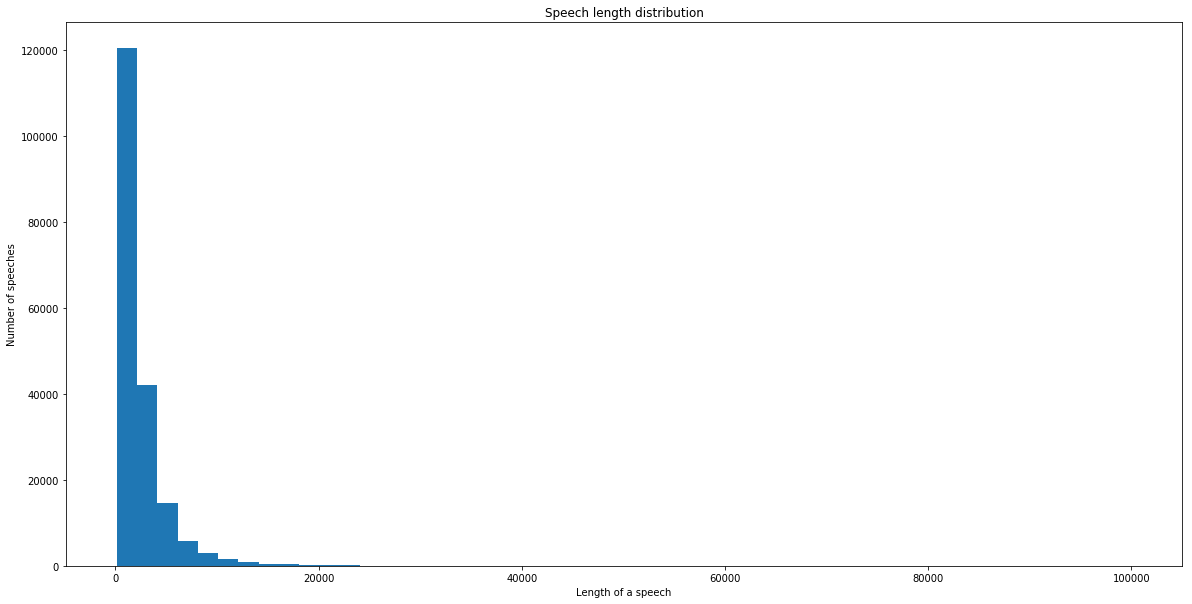

In [20]:
reload(explore_data)
explore_data.plot_sample_length_distribution(train)

In [21]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 750

vec_params = {
    'num_words': TOP_K,
    'max_length': MAX_SEQUENCE_LENGTH
}

In [22]:
reload(preprocess_data)
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train, val, test, **vec_params)

In [23]:
len(train), len(val), len(test)

(189914, 63304, 63308)

In [24]:
len(train_vec), len(val_vec), len(test_vec)

(189914, 63304, 63308)

In [25]:
train_vec[0].shape

(750,)

In [27]:
word_index['woman']

737

## SepCNN Model

Source: https://developers.google.com/machine-learning/guides/text-classification/step-4

In [28]:
import tensorflow as tf

from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

In [29]:
def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """
    Source: https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/build_model.py
    
    Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    
    # adjust this if using more than two classes in target
    op_units, op_activation = 1, 'sigmoid'
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [30]:
logs_base_dir = "/home/yulia/final-project/Classification/logs"

In [31]:
class TimeHistory(tf.keras.callbacks.Callback):
    """
    https://stackoverflow.com/questions/43178668/
    record-the-computation-time-for-each-epoch-in-keras-during-model-fit
    """
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [32]:
def train_sequence_model(data,
                         word_index,
                         learning_rate=1e-3,
                         epochs=1000,
                         batch_size=128,
                         blocks=2,
                         filters=64,
                         dropout_rate=0.2,
                         embedding_dim=200,
                         kernel_size=3,
                         pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of vectorized training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (x_train, train_labels), (x_val, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = 2
    
    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance.
    model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features)

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=2),
        tf.keras.callbacks.TensorBoard(log_dir=logs_base_dir, 
                                       histogram_freq=0, 
                                       write_graph=True, 
                                       write_images=True),
        TimeHistory()]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    train_pred_probs = model.predict(x_train)
    val_pred_probs = model.predict(x_val)

    return history, train_pred_probs, val_pred_probs

#     # Save model.
#     model.save('rotten_tomatoes_sepcnn_model.h5')
#     return history['val_acc'][-1], history['val_loss'][-1]

In [34]:
history, train_pred_probs, val_pred_probs = train_sequence_model(((train_vec, train_target), (val_vec, val_target)), word_index)

/home/yulia/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 189914 samples, validate on 63304 samples
Epoch 1/1000
 - 1400s - loss: 0.6315 - acc: 0.6459 - val_loss: 0.5704 - val_acc: 0.7051
Epoch 2/1000
 - 1403s - loss: 0.5616 - acc: 0.7173 - val_loss: 0.5525 - val_acc: 0.7246
Epoch 3/1000
 - 1397s - loss: 0.5360 - acc: 0.7351 - val_loss: 0.5418 - val_acc: 0.7306
Epoch 4/1000
 - 1395s - loss: 0.5190 - acc: 0.7458 - val_loss: 0.5415 - val_acc: 0.7351
Epoch 5/1000
 - 1391s - loss: 0.5053 - acc: 0.7525 - val_loss: 0.5601 - val_acc: 0.7127
Epoch 6/1000
 - 1393s - loss: 0.4888 - acc: 0.7626 - val_loss: 0.5497 - val_acc: 0.7308
Validation accuracy: 0.7308069000303798, loss: 0.5497461121256758


## Model evaluation

In [35]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

46263

Confusion matrix, without normalization
[[21667  9985]
 [ 7056 24596]]


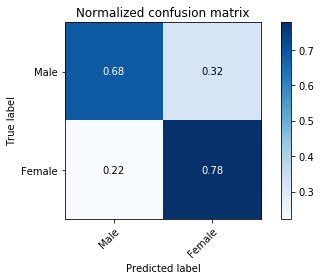

In [36]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

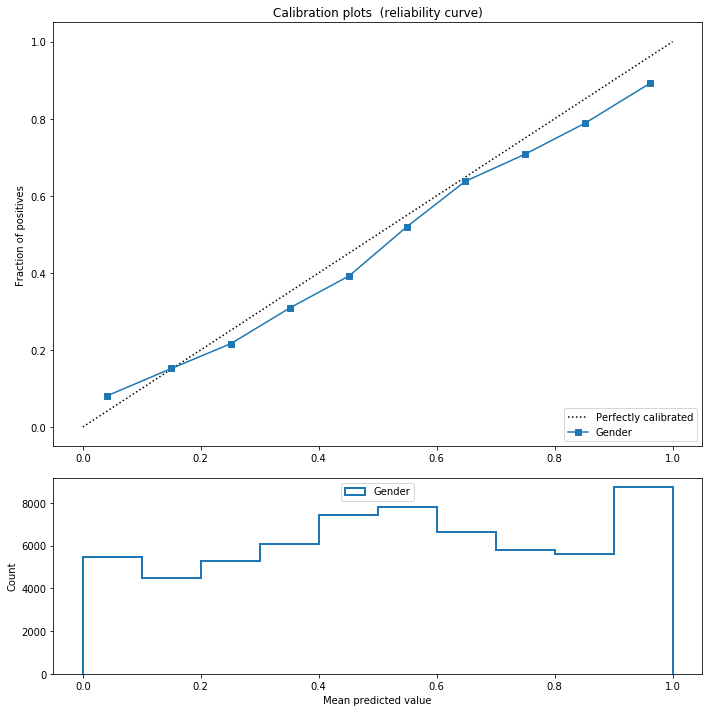

In [37]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [38]:
val_random = np.random.choice(a=[0,1], size=len(val_target), p = [0.7,0.3])
val_random.sum()/val_random.shape[0]

0.2952578036143056

In [39]:
# val_target_sample = np.array(val_target)[val_random==1]
val_sample = np.array(val)[val_random==1]
val_ids_sample = np.array(val_ids)[val_random==1]
val_pred_probs_sample = val_pred_probs[val_random==1]
val_sample.shape, val_ids_sample.shape, val_pred_probs_sample.shape

MemoryError: 

In [48]:
reload(explore_data)
explore_data.check_bin_probs_distr(val_pred_probs_sample, val_ids_sample, descr)

Finished building main df
Finished bin 0.4
Finished bin 0.6
Finished bin 1.0


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.64,0.83,1.04,0.79,0.74,0.72
0.6,0.88,2.06,1.00,1.05,0.95,0.95
1.0,1.33,0.61,0.97,1.13,1.22,1.23


In [65]:
len(train)

990

In [69]:
len(val)

330

In [ ]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs)

In [41]:
reload(explore_data)
explore_data.ngrams_by_bin(val_sample, val_pred_probs_sample)


In 0.4 bin top 10 ngrams:

would like to
the gentleman from
unanimous consent that
the federal government
of my amendment
in order to
in connection with
ask unanimous consent that
ask unanimous consent
to do so
--------------------

In 0.6 bin top 10 ngrams:

the st lawrence seaway
the st lawrence
st lawrence seaway
for health planning
the insanity defense
the gentleman from
that there is
st lawrence seaway development
percent of the
of health care
--------------------

In 1.0 bin top 10 ngrams:

would like to
armed services committee
the gentleman from
the soviet union
the armed services committee
the armed services
the united states
the office of
one of the
urge my colleagues
--------------------


In [57]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr)

15

True positive (Predicted prob: 0.94):

speakerid 97106680.0
Female 1.0
Ethnicity W
State NY
match exact
date 19820126
Age 47.0
Full Name FERRARO, GERALDINE
word_count 270
Chamber H
Congress 97
speaker Ms. FERRARO
Party D
Age_lt_med 1.0
NonWhite 0.0
char_count 1748

 Mr. Speaker. January 22. 1918. commemorates an important and emotional day in Ukrainian history. It was on this day that the people of the Ukraine achieved their freedom and independence from their powerful neighbors. This freedom and independence. however. was short lived. By 1920 the Ukrainian independent state was crushed by a more powerful Soviet Government. As Americans. we direct our attention to the plight of the Ukrainian people for several reasons. First. the Ukraine is the largest nonRussian nation both within the Soviet Union and all of Eastern Europe. Second. as Americans. most of us have not been subjected to harassment. arrest or persecution because of our personal beliefs. The United States has the right 